## Лабораторная работа №1 по системам обработки больших данных

### Импортирование модулей

In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *
from functools import reduce
from pyspark.sql import functions 
from pyspark.sql.types import *
from pyspark.sql.functions import col

MAX_MEMORY = '8G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Lab1") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

filename_data = 'data/the-reddit-covid-dataset-comments.csv'
df = spark.read.csv(filename_data, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [3]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)

Columns overview


,Column Name,Data type
0,_c0,string
1,_c1,string
2,_c2,string
3,_c3,string
4,_c4,string
5,_c5,string
6,_c6,string
7,_c7,string
8,_c8,string
9,_c9,string


In [4]:
new_column_names = {
    "_c0": "type",
    "_c1": "id",
    "_c2": "subreddit_id",
    "_c3": "subreddit_name",
    "_c4": "subreddit_nsfw",
    "_c5": "created_utc",
    "_c6": "permalink",
    "_c7": "body",
    "_c8": "sentiment",
    "_c9": "score",
}

for c, new_c in new_column_names.items():
    df = df.withColumnRenamed(c, new_c)

df = df.withColumn("subreddit_nsfw", col("subreddit_nsfw").cast(BooleanType()))
df = df.withColumn("sentiment", col("sentiment").cast(FloatType()))
df = df.withColumn("score", col("score").cast(IntegerType()))

df.printSchema()
df.show()

root
 |-- type: string (nullable = true)
 |-- id: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- subreddit_name: string (nullable = true)
 |-- subreddit_nsfw: boolean (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- body: string (nullable = true)
 |-- sentiment: float (nullable = true)
 |-- score: integer (nullable = true)

+-------+-------+------------+--------------------+--------------+-----------+--------------------+--------------------+---------+-----+
|   type|     id|subreddit_id|      subreddit_name|subreddit_nsfw|created_utc|           permalink|                body|sentiment|score|
+-------+-------+------------+--------------------+--------------+-----------+--------------------+--------------------+---------+-----+
|   type|     id|subreddit.id|      subreddit.name|          NULL|created_utc|           permalink|                body|     NULL| NULL|
|comment|hi1vsag|       2riyy|           

In [5]:
df = df.dropna()
df.show()

+-------+-------+------------+--------------------+--------------+-----------+--------------------+--------------------+---------+-----+
|   type|     id|subreddit_id|      subreddit_name|subreddit_nsfw|created_utc|           permalink|                body|sentiment|score|
+-------+-------+------------+--------------------+--------------+-----------+--------------------+--------------------+---------+-----+
|comment|hi1vsag|       2riyy|                nova|         false| 1635206399|https://old.reddi...|When you schedule...|      0.0|    2|
|comment|hi1vs0l|       2qsf3|             ontario|         false| 1635206395|https://old.reddi...|Compare BC to Ont...|      0.0|   -2|
|comment|hi1vrnr|      2iokxd|  lockdownskepticism|         false| 1635206391|https://old.reddi...|And think about h...|  -0.8413|   29|
|comment|hi1vrou|       384mz|         antivaxxers|         false| 1635206391|https://old.reddi...|I don’t know anyo...|  -0.9191|    1|
|comment|hi1vrg2|       2qh4r|          c

In [6]:
quantiles = df.approxQuantile("score", [0.25, 0.75], 0.05)  # 25-й и 75-й процентили
IQR = quantiles[1] - quantiles[0]
lower_bound = quantiles[0] - 1.5 * IQR
upper_bound = quantiles[1] + 1.5 * IQR
df = df.filter((col("score") >= lower_bound) & (col("score") <= upper_bound))
quantiles = df.approxQuantile("score", [0.25, 0.75], 0.05)  # 25-й и 75-й процентили
IQR = quantiles[1] - quantiles[0]
lower_bound = quantiles[0] - 1.5 * IQR
upper_bound = quantiles[1] + 1.5 * IQR
df = df.filter((col("score") >= lower_bound) & (col("score") <= upper_bound))
df.count()

6200460

<Figure size 640x480 with 0 Axes>

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2a7d5e5790>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2a7d5e7190>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2aa3425c10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2a76f40b50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2a76f416d0>],
 'means': []}

Text(0.5, 1.0, 'Score')

Text(0, 0.5, 'Values')

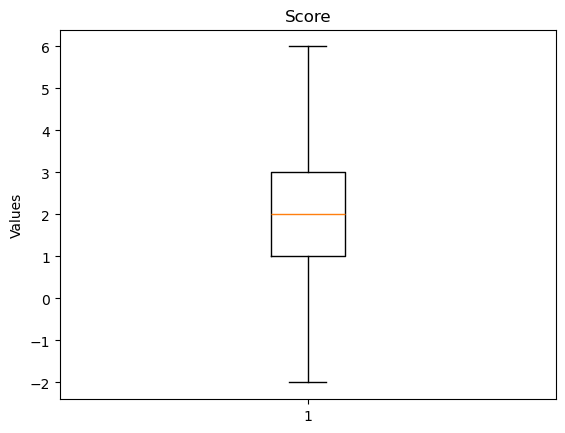

In [7]:
score_df = df.select("score")
pd_score_df = score_df.toPandas()
plt.figure()
plt.boxplot(pd_score_df['score'])
plt.title('Score')
plt.ylabel('Values')
plt.show()

In [8]:
quantiles1 = df.approxQuantile("score", [0.5], 0.05)
median_score = quantiles1[0]
print(f'Median score: {median_score}\n')
df.select('score').describe().show()

Median score: 2.0

+-------+------------------+
|summary|             score|
+-------+------------------+
|  count|           6200460|
|   mean|1.9619768533302369|
| stddev|1.6119229153550836|
|    min|                -2|
|    max|                 6|
+-------+------------------+



**count** - Количество строк\
**mean** - Среднее значение\
**stddev** - Стандартное отклонение\
**min** - Минимальное значение\
**max** - Максимальное значение

(array([  78541.,       0.,  134144.,       0.,       0.,  344473.,
              0., 2500793.,       0.,       0., 1361856.,       0.,
         783894.,       0.,       0.,  373703.,       0.,  352950.,
              0.,  270106.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ,
         2.4,  2.8,  3.2,  3.6,  4. ,  4.4,  4.8,  5.2,  5.6,  6. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Score')

Text(0.5, 0, 'Score')

Text(0, 0.5, 'Frequency')

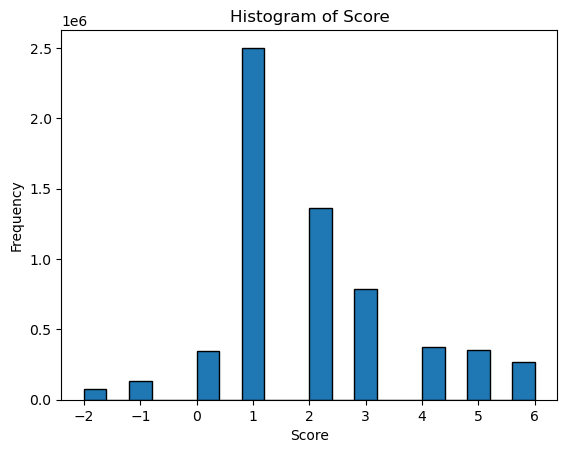

In [9]:
score_df = df.select("score").rdd.flatMap(lambda x: x).collect()
plt.hist(score_df, bins=20, edgecolor='black')
plt.title('Histogram of Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

(array([ 200803.,  273858.,  270084.,  256587.,  311022.,  277734.,
         246623.,  287735.,  198973.,  144042., 1045494.,  191932.,
         270478.,  279818.,  383241.,  306599.,  306997.,  327855.,
         338521.,  282064.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Sentiment')

Text(0.5, 0, 'Sentiment')

Text(0, 0.5, 'Frequency')

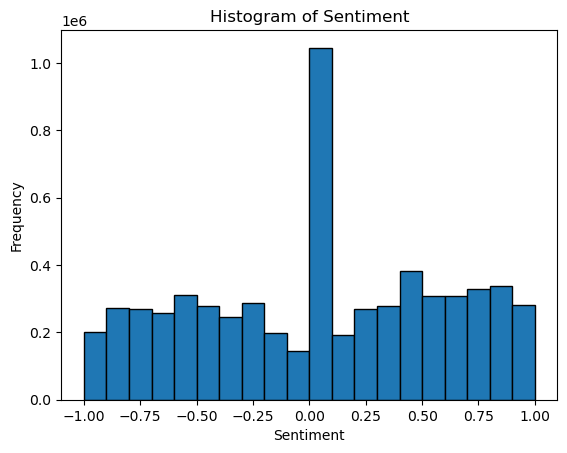

In [10]:
sentiment_df = df.select("sentiment").rdd.flatMap(lambda x: x).collect()
plt.hist(sentiment_df, bins=20, edgecolor='black')
plt.title('Histogram of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Number of NSFW and Non-NSFW Posts')

Text(0.5, 0, 'Subreddit NSFW')

Text(0, 0.5, 'Count')

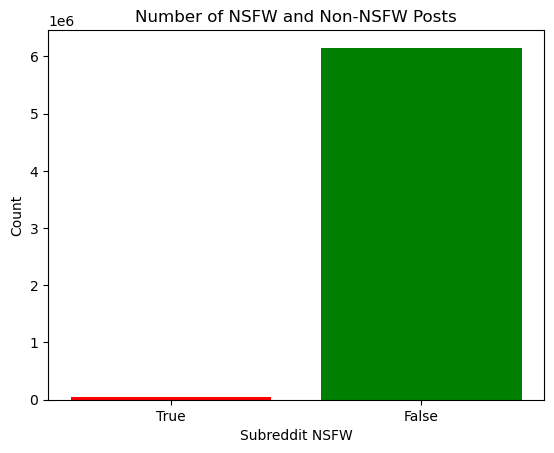

In [11]:
count_values = df.groupBy("subreddit_nsfw").count().collect()

# Извлечение значений
values = [x['count'] for x in count_values]
categories = [str(x['subreddit_nsfw']) for x in count_values]

# Построение столбчатой диаграммы
plt.bar(categories, values, color=['red', 'green'])
plt.title('Number of NSFW and Non-NSFW Posts')
plt.xlabel('Subreddit NSFW')
plt.ylabel('Count')
plt.show()

In [12]:
count_nsfw_posts = df.filter(df["subreddit_nsfw"] == True).count()
print(f'Количество постов с NSFW: {count_nsfw_posts}\n')

Количество постов с NSFW: 49842



In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
selected_data = df.select("score", "sentiment")

assembler = VectorAssembler(inputCols=["score", "sentiment"], outputCol="features")
assembled_data = assembler.transform(selected_data)
correlation_matrix = Correlation.corr(assembled_data, "features").head()
corr_matrix = correlation_matrix[0].toArray()
correlation_df = spark.createDataFrame(corr_matrix, ["score", "sentiment"])

correlation_df.show()

+-------------------+-------------------+
|              score|          sentiment|
+-------------------+-------------------+
|                1.0|0.01509838570648511|
|0.01509838570648511|                1.0|
+-------------------+-------------------+

